In [2]:
using NBInclude
@nbinclude("julia_function.ipynb")

allskyevents_free_eres (generic function with 1 method)

In [101]:
# Getting the true energy resolution matrix

true_eres = readdlm("eres_matrix.dat")
true_eres[1:25, 175:end] = zeros(25, 26)

true_eres = 10 .^ true_eres

for j in 1:200
    for i in 1:200
        if true_eres[i, j] == 1
            true_eres[i, j] = 0
        end
    end
end

erestrue = transpose(true_eres)

loges = range(log10(5e-1), log10(4e3), 200)
du = loges[2] - loges[1]

# eresnorm = (1/0.11711890233208494) # Needed to actually normalize the columns, not precise (might have to go about being more precise here)

0.019613517522572566

In [82]:
# sum(erestrue[:,100]*du)
# Normalizing the columns
for i in 1:200
    normconst = sum(erestrue[:,i]*du)
    erestrue[:,i] .= erestrue[:,i]/normconst
end

In [85]:
sum(erestrue[:,100]*du)

1.0

In [104]:
sum(unique(erestrue[:,170]))

0.8122653620603826

In [117]:
rbins = range(0.2, stop=20.2, step=0.2)
length(rbins)

101

In [124]:
# New event distribution function

function smedist(dm2, l, b, ϕ₀, γ, θ)

    # Mutates emptymat and ur
    function fstrippedmat!(emptymat, ur, dm2, l, b, θ, ϕ₀, γ)
        ur .= 10 .^ ur
        r0, rmax = 0.2, 20.2
        blength = 0.2
        rbins = range(r0, stop=rmax, step=blength)
        for i in 1:length(ur)
            for j in 1:length(rbins)
                vols = blength * oscprob(ur[i], dm2, rbins[j]) * sbinarea(rbins[j], l, b, θ) * (1/(rbins[j]^2))
                emptymat[j, i] = vols
            end 
        end
        flx = fluxfreeparams1(ur, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
        vec(sum(flx .* emptymat, dims=1)) .* (effarea.(ur) * 10000)
    end

    emptymat = zeros(101, length(loges)) # 61 from the sampling frequency along r
    fsample = fstrippedmat!(emptymat, collect(loges), dm2, l, b, θ, ϕ₀, γ)

    fsmeared = erestrue * fsample * du
end

# For binned edist:
function smedistbinned(dm2, l, b, ϕ₀, γ, θ)
    unbinned_vec = smedist(dm2, l, b, ϕ₀, γ, θ)
    nbins = 25 # An admittedly arbitrary number of bins, should probably find a more intelligent number
    nsteps = 200
    steps = unbinned_vec .* du .* (10 .^ loges) .* log(10)
    matrix = reshape(steps, (8, :)) # This 8 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums) * 303.3578031561753 # This factor is to make the total sum over all sky to be 748
end

smedistbinned (generic function with 3 methods)

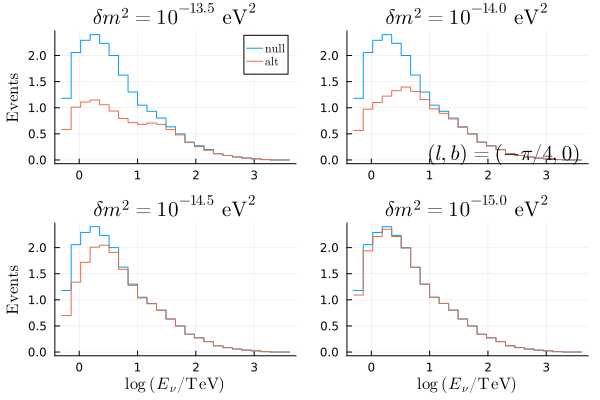

In [151]:
# Plotting different dm2 values

l0 = -π/4
b0 = 0

nullsmear = smedistbinned(0, l0, b0, 21.8, 2.7, 0.122)
binned_us = range(log10(5e-1), log10(4e3), 25)
p135 = plot(
    binned_us,
    [nullsmear smedistbinned(10^(-13.5), l0, b0, 21.8, 2.7, 0.122)],
    seriestype=:step,
    ylabel=L"\mathrm{Events}",
    title=L"\delta m^2 = 10^{-13.5}~\mathrm{eV^2}",
    label=[L"\mathrm{null}" L"\mathrm{alt}"]
)

p140 = plot(
    binned_us,
    [nullsmear smedistbinned(10^(-14), l0, b0, 21.8, 2.7, 0.122)],
    seriestype=:step,
    title=L"\delta m^2 = 10^{-14.0}~\mathrm{eV^2}",
    label=false,
    ann=[(2.3, 0.1, L"(l, b) = (-\pi/4, 0)")]
)

p145 = plot(
    binned_us,
    [nullsmear smedistbinned(10^(-14.5), l0, b0, 21.8, 2.7, 0.122)],
    seriestype=:step,
    xlabel=L"\log~(E_{\nu}/\mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    title=L"\delta m^2 = 10^{-14.5}~\mathrm{eV^2}",
    label=false
)

p150 = plot(
    binned_us,
    [nullsmear smedistbinned(10^(-15), l0, b0, 21.8, 2.7, 0.122)],
    seriestype=:step,
    xlabel=L"\log~(E_{\nu}/\mathrm{TeV})",
    title=L"\delta m^2 = 10^{-15.0}~\mathrm{eV^2}",
    label=false
)

plot(p135, p140, p145, p150, layout=(2, 2))

In [126]:
function allskyevents2(dm2, ϕ₀, γ, nb)
    bsize = π/nb

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = [zeros(25) for _ in 1:length(b_range), _ in 1:length(l_range)]

    for (j, l) in enumerate(l_range)
        for (i, b) in enumerate(b_range)
            if i > nb/4 && i < 3*nb/4
                skybins[i, j] = smedistbinned(dm2, l, (-b), ϕ₀, γ, bsize)
            end
        end
    end

    return sum(skybins)
end

allskyevents2 (generic function with 1 method)

In [127]:
testasevents = allskyevents2(0, 21.8, 2.7, 100)

25-element Vector{Float64}:
 43.81528877804493
 76.34739186908239
 85.06009785174155
 89.11760033849916
 82.94638491230343
 74.26724177658592
 60.34208333914512
 48.294278098370825
 38.96894418194675
 34.57153526376746
 29.828879341421068
 23.53992271237703
 18.533896985074072
 12.669148735309474
 10.102612094436633
  7.393360651762202
  4.446434544074871
  3.152816493387318
  2.1260644826113486
  1.3609834284700486
  0.8340322184541196
  0.26856735569761236
  0.006224111344704449
  0.004480357587729208
  0.001730078504225146

In [128]:
sum(testasevents)

748.0

In [123]:
748/sum(testasevents)

303.3578031561753

In [93]:
old_testasevents = allskyevents_free_eres(0, 21.8, 2.7, 0.2, 100)

50-element Vector{Float64}:
 11.130644860998737
 18.361362619696255
 24.05564663960427
 27.567026700269736
 30.087508082040706
 32.177577853912815
 33.850128206683706
 35.096788383309594
 35.98258154594774
 36.488355459272256
 36.58121429090127
 36.29200395003596
 35.476000352188436
  ⋮
  2.6486043011248412
  2.2916688689631695
  1.9737193986649735
  1.6943367935674063
  1.4557922781923671
  1.2499198669303273
  1.067030745159355
  0.9023004093973219
  0.7549292857866077
  0.6247030828126299
  0.5013459409962904
  0.361433458191934

In [94]:
sum(old_testasevents)

790.1186743504917